In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torch.utils.data import Dataset ,DataLoader
from torchvision import datasets
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import time
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import StepLR
import io
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # Regular tqdm, not tqdm.auto
import os






In [12]:
import torch
print(torch.__version__)        # Powinno zawierać cu118
print(torch.version.cuda)       # Np. '11.8'
print(torch.cuda.is_available())# True jeśli GPU dostępne
print(torch.cuda.device_count())# liczba GPU




2.8.0+cpu
None
False
0


In [13]:


class SudokuDatasetOneHot(Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.puzzles = data['puzzles']     # shape: (N, 9, 9, 10)
        self.solutions = data['solutions'] # shape: (N, 9, 9, 10)
        self.hole_count = data['hole_counts']
        self.id = data['ids']

        # Walidacja
        assert isinstance(self.puzzles, torch.Tensor)
        assert isinstance(self.solutions, torch.Tensor)
        assert self.puzzles.shape == self.solutions.shape, (
            f"Shapes mismatch: puzzles {self.puzzles.shape}, solutions {self.solutions.shape}"
        )

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        x = self.puzzles[idx]     # shape: (9, 9, 10)
        y = self.solutions[idx]   # shape: (9, 9, 10)

        # Zamiana wymiarów: (9, 9, 10) → (10, 9, 9)
        x = x.permute(2, 0, 1).float()
        y = y.permute(2, 0, 1).float()

        return x, y


In [ ]:
#data size for normal non - onehot encoded are (N , 9 , 9)

class SudokuDataset(Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.puzzles = data['puzzles']     
        self.solutions = data['solutions'] 
        self.hole_count = data['hole_counts']
        self.id = data['ids']

        # Walidacja
        assert isinstance(self.puzzles, torch.Tensor)
        assert isinstance(self.solutions, torch.Tensor)
        assert self.puzzles.shape == self.solutions.shape, (
            f"Shapes mismatch: puzzles {self.puzzles.shape}, solutions {self.solutions.shape}"
        )

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        x = self.puzzles[idx]     # shape: (9, 9, 10)
        y = self.solutions[idx]   # shape: (9, 9, 10)

        # Zamiana wymiarów: (9, 9, 10) → (10, 9, 9)
        x = x.unsqueeze(0).float()
        y = y.unsqueeze(1).float()

        return x, y

In [15]:
full_dataset = SudokuDataset("../DataGeneration/data/data2.pt")

In [21]:
print(full_dataset.puzzles.shape)
print(full_dataset.solutions.shape)

torch.Size([1000000, 9, 9])
torch.Size([1000000, 9, 9])


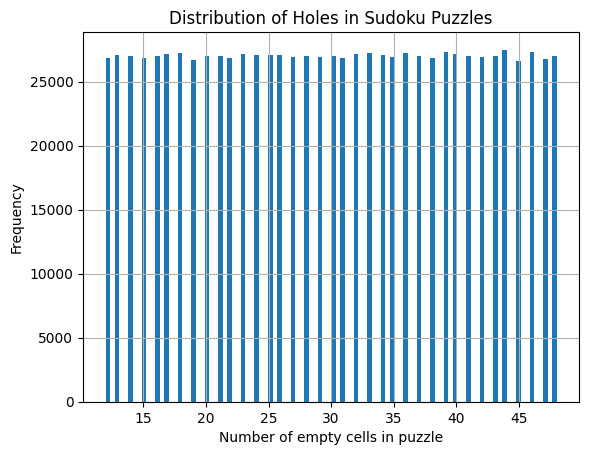

In [17]:
plt.hist(full_dataset.hole_count, bins=100)
plt.xlabel('Number of empty cells in puzzle')
plt.ylabel('Frequency')
plt.title('Distribution of Holes in Sudoku Puzzles')
plt.grid(True)
plt.show()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class ModelFit():

    def __init__(self):
        self.model = None
        self.device = None
        self.writer = None
        self.scheduler = None  # Add this

        # Create writer
        
        
    
    def get_model(self,learning_rate , load_path = None ,loss_func = nn.CrossEntropyLoss(), device = 'cpu' , optim = None , model = None):


        self.device = torch.device('cuda' if torch.cuda.is_available() and device != 'cpu' else 'cpu')
        if model:
            self.model = model
        if  self.model is None:
            raise ValueError("No model available. Either pass a model parameter or set self.model first")


        if load_path:
            self.model.load_state_dict(torch.load(load_path, map_location=self.device))
      

        if optim:
            self.optimizer = optim
        elif  not optim:
            self.optimizer  = torch.optim.Adam(self.model.parameters(), lr=learning_rate)


        self.model_name = self.model.__class__.__name__
        self.timestamp = time.strftime("%H_%M_S-%d-%M-%Y")
        self.log_dir = f"runs/real_data/{self.model_name}_{self.timestamp}"
        self.writer = SummaryWriter(log_dir=self.log_dir)

        
            
            

        return self.model , self.optimizer , loss_func



    def loss_batch(self,model, loss_func, xb, yb, opt=None):
        xb, yb = xb.to(self.device , non_blocking = True), yb.to(self.device, non_blocking = True)
        preds = model(xb)
        loss = loss_func(preds, yb)

        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()

        return loss.item(), len(xb)
    
    
    
    def train_loss_over_batches(self,training_data,current_epoch,epoches,loss_func,opt):
        total_loss = 0
        count = 0
        self.model.train()

        progress_bar = tqdm(training_data, desc=f"Epoch {current_epoch+1}/{epoches}", leave=True)
        
        for xb, yb in progress_bar:
            xb, yb = xb.to(self.device), yb.to(self.device)
            loss, batch_size = self.loss_batch(self.model, loss_func, xb, yb, opt)
            total_loss += loss * batch_size
            count += batch_size
            progress_bar.set_postfix(train_loss=total_loss / count)
            train_loss = total_loss / count
            self.writer.add_scalar('Loss/train', train_loss, count)
        progress_bar.close()
        
        if self.scheduler is not None:
            self.scheduler.step()
        return train_loss

    def valid_loss_over_batches(self,validation_data,current_epoch,epoches,loss_func ):
        self.model.eval()
        val_losses = []
        val_nums = []

        with torch.no_grad():
            for xb, yb in validation_data:
                xb, yb = xb.to(self.device, non_blocking = True), yb.to(self.device, non_blocking = True)
                loss, batch_size = self.loss_batch(self.model, loss_func, xb, yb)
                val_losses.append(loss)
                val_nums.append(batch_size)

        val_loss = np.sum(np.multiply(val_losses, val_nums)) / np.sum(val_nums)
        self.writer.add_scalar('Loss/val', val_loss, current_epoch)

        return val_loss
    
    def model_training(self ,
                        epoches ,
                        loss_func ,
                        optimalizator , 
                        training_data , 
                        validation_data , 
                        weight_unfreeze_epoch,
                        scheduler_step_size , 
                        scheduler_gamma):
        
        self.model.to(self.device)
        self.scheduler = lr_scheduler.StepLR(optimalizator, step_size=scheduler_step_size, gamma=scheduler_gamma )  

        for epoch in range(epoches):
            if epoch == weight_unfreeze_epoch:
                for param in self.model.features.parameters():
                    param.requires_grad = True
            
            
            
            self.train_loss_over_batches(training_data=training_data,
                                         current_epoch=epoch,
                                         epoches=epoches,
                                         loss_func=loss_func,
                                         opt = optimalizator)
            self.valid_loss_over_batches(epoches = epoches , current_epoch= epoch , validation_data= validation_data , loss_func=loss_func )
        self.save_model()
        return self.model

    def save_model(self,filename="model.pt"):
        if self.model is None:
            raise ValueError("no model to save.")
        
        os.makedirs(self.log_dir, exist_ok=True)
        path = os.path.join(self.log_dir, filename)

        checkpoint = {
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': getattr(self, 'optimizer', None).state_dict() if hasattr(self, 'optimizer') else None
        }
        torch.save(checkpoint, path)
        print(f"Model saved: {path}")
    
    def model_testing(self,
                      test_loader,
                      loss_func,
                      class_names=None):
        self.model.eval()
        self.model.to(self.device)

        total_correct = 0
        total_samples = 0
        total_loss = 0

        all_preds = []
        all_labels = []
        progress_bar = tqdm(test_loader, desc="Testing", leave=False)
        with torch.no_grad():
            for xb, yb in progress_bar:
                yb = yb.squeeze(1)
                xb, yb = xb.to(self.device), yb.to(self.device)
                outputs = self.model(xb)
                loss = loss_func(outputs, yb)

                total_loss += loss.item() * xb.size(0)

                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == yb).sum().item()
                total_samples += yb.numel() 

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        progress_bar.close()

        avg_loss = total_loss / total_samples
        accuracy = total_correct / total_samples

        print(f"\nTest Loss: {avg_loss:.4f}")
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        fig, ax = plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else range(cm.shape[1]),
                    yticklabels=class_names if class_names else range(cm.shape[0]))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix\nLoss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
        plt.tight_layout()
        """
        if self.writer:
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            self.writer.add_figure("Confusion Matrix", buf, global_step=1)
            image = Image.open(buf)
            image = transforms.ToTensor()(image)
            self.writer.add_image("Confusion_Matrix", image ,1)
        plt.show()
        """
        if self.writer:
            self.writer.add_figure("Confusion Matrix", fig, global_step=1)

        plt.show()



        return avg_loss, accuracy, cm

    

NameError: name 'nn' is not defined

In [20]:
class SudokuNet(nn.Module):
    def __init__(self):
        super(SudokuNet,self).__init__()
        self.conv_layer_1 = nn.Sequential(
            #input should be (n,1,9,9)
            nn.Conv2d(in_channels=1 , out_channels=32 , kernel_size=3 ,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #after layer size is (9,9,32)

            nn.Conv2d(in_channels = 32 , out_channels=64,kernel_size = 3 , padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            #after layer size is (9,9,64)

            nn.Conv2d(in_channels = 64 , out_channels=128,kernel_size = 3 , padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            #after layer size is (9,9,128)
            nn.Conv2d(in_channels = 128 , out_channels=256,kernel_size = 3 , padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            #after layer size is (9,9,256)
        )
        self.classification_layer = nn.Sequential(
            nn.Conv2d(in_channels=256 , out_channels=9 , kernel_size=1 ,padding=1)
            
        )
    def forward(self,x):
        x = self.conv_layer_1(x)
        x = self.classification_layer(x)
        return x
        
model = SudokuNet().to(device)
        

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
workers_num =5
# Loaders
pin_memory_state = False
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,pin_memory=pin_memory_state, num_workers=workers_num)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False,pin_memory=pin_memory_state, num_workers=workers_num)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False,pin_memory=pin_memory_state, num_workers=workers_num)




model = SudokuNet()

# Create trainer and get components
trainer = ModelFit()
model, optimizer, loss_func = trainer.get_model(
    learning_rate=1e-3, 
    model=model
)

# Train (using the returned optimizer and loss_func)
trainer.model_training(
    epoches=1,
    loss_func=loss_func,
    optimalizator=optimizer,  # Use the one returned by get_model
    training_data=train_loader,
    validation_data=val_loader,
    weight_unfreeze_epoch=None,
    scheduler_step_size=5,
    scheduler_gamma=0.5)

Epoch 1/1:   0%|          | 0/6250 [00:00<?, ?it/s]

In [12]:


class SimpleSudokuCNN(nn.Module):
    def __init__(self):
        super(SimpleSudokuCNN, self).__init__()
        # wejście: (batch, 10, 9, 9)
        self.conv1 = nn.Conv2d(10, 32, kernel_size=3, padding=1)  # (batch, 32, 9, 9)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (batch, 64, 9, 9)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (batch, 128, 9, 9)
        
        self.dropout = nn.Dropout(0.3)
        
        # ostatnia warstwa konwolucyjna zmienia liczbę kanałów na 9 (klasy od 0 do 8)
        self.conv_out = nn.Conv2d(128, 9, kernel_size=1)           # (batch, 9, 9, 9)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.conv_out(x)  # logits dla każdej klasy na każdej pozycji
        # output shape: (batch, 9, 9, 9)
        # Jeśli potrzebujesz (batch, 9, 9, 9), permutuj: x.permute(0, 2, 3, 1)
        return x





# losowe dane: batch 100, 10 kanałów, 9x9 sudoku one-hot
x_dummy = torch.randn(10000, 10, 9, 9)
# losowe etykiety: batch 100, 9x9, klasa od 0 do 8
y_dummy = torch.randint(0, 9, (10000, 9, 9))

dataset = TensorDataset(x_dummy, y_dummy)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset, batch_size=128)



train_dataset = TensorDataset(x_dummy, y_dummy)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64)  # użyj tego samego jako walidacji

# Model i trenowanie
# Define model first
model = SimpleSudokuCNN()

# Create trainer and get components
trainer = ModelFit()
model, optimizer, loss_func = trainer.get_model(
    learning_rate=1e-3, 
    model=model
)

# Train (using the returned optimizer and loss_func)
trainer.model_training(
    epoches=10,
    loss_func=loss_func,
    optimalizator=optimizer,  # Use the one returned by get_model
    training_data=train_loader,
    validation_data=val_loader,
    weight_unfreeze_epoch=None,
    scheduler_step_size=5,
    scheduler_gamma=0.5)

Epoch 10/10: 100%|██████████| 157/157 [00:05<00:00, 27.83it/s, train_loss=2.18]


Model saved: runs/real_data/SimpleSudokuCNN_21_04_S-25-04-2025\model.pt


SimpleSudokuCNN(
  (conv1): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (conv_out): Conv2d(128, 9, kernel_size=(1, 1), stride=(1, 1))
)